# ===============================================================
# üìú Notebook Summary (read me first) - CSE521p-dinov2-rf-detr
# ===============================================================
This notebook implements a **DINOv2-style self-supervised pretrain**
on the **RF-DETR Nano** detector (we extract deep backbone features with
hooks), then fine-tune RF-DETR on your labeled data, evaluate, and visualize
learned features via **PCA**.

# What you get
   1) COCO ‚Üí YOLO-style split (images/labels + data.yaml).
   2) SSL pretraining (DINOv2-style):
       ‚Ä¢ Student/Teacher (EMA w/ cosine momentum)
       ‚Ä¢ Multi-crop: 2 global + 8 local
       ‚Ä¢ Teacher temp warmup + centering
       ‚Ä¢ Cross-view CE between teacher probs (global) and student logits (all)
   3) Save ONLY the SSL-pretrained backbone weights (compatible with RF-DETR).
   4) Fine-tune **RF-DETR Nano** with your data via `rfdetr`.
   5) Evaluate (mAP etc.) + visualize one prediction.
   6) PCA of SSL features (clustered with k-means).

# ‚ö†Ô∏è Notes:
   ‚Ä¢ This is a **DINOv2-style adaptation** for RF-DETR Nano (transformer detector).
     Official DINOv2 targets ViTs; here we feature-tap RF-DETR‚Äôs deep CNN/neck
     tensor via robust forward hooks, then do projector-head contrast.
   ‚Ä¢ For stronger transfer, push SSL_EPOCHS to 50‚Äì100 and add more (even unlabeled) images.
# ===============================================================

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.1/1.1 MB 8.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 64.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 60.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

/tmp/ipykernel_19/3786460526.py:274: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 01: loss=6.4901


SSL Ep 2/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 02: loss=4.5718


SSL Ep 3/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 03: loss=4.5761


SSL Ep 4/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 04: loss=5.1542


SSL Ep 5/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 05: loss=6.3570


SSL Ep 6/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 06: loss=7.5426


SSL Ep 7/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 07: loss=8.0220


SSL Ep 8/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 08: loss=7.6091


SSL Ep 9/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 09: loss=6.6462


SSL Ep 10/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 10: loss=6.1087


SSL Ep 11/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 11: loss=6.1988


SSL Ep 12/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 12: loss=6.0154


SSL Ep 13/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 13: loss=6.0181


SSL Ep 14/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 14: loss=6.1374


SSL Ep 15/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 15: loss=5.8949


SSL Ep 16/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 16: loss=5.8893


SSL Ep 17/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 17: loss=5.7486


SSL Ep 18/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 18: loss=5.6938


SSL Ep 19/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 19: loss=5.7688


SSL Ep 20/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 20: loss=5.6067


SSL Ep 21/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 21: loss=5.5669


SSL Ep 22/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 22: loss=5.5654


SSL Ep 23/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 23: loss=5.5632


SSL Ep 24/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 24: loss=5.5512


SSL Ep 25/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 25: loss=5.5457


SSL Ep 26/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 26: loss=5.5443


SSL Ep 27/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 27: loss=5.5436


SSL Ep 28/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 28: loss=5.5403


SSL Ep 29/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 29: loss=5.5400


SSL Ep 30/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 30: loss=5.5406


SSL Ep 31/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 31: loss=5.5365


SSL Ep 32/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 32: loss=5.5369


SSL Ep 33/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 33: loss=5.5348


SSL Ep 34/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 34: loss=5.5349


SSL Ep 35/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 35: loss=5.5340


SSL Ep 36/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 36: loss=5.5336


SSL Ep 37/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 37: loss=5.5343


SSL Ep 38/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 38: loss=5.5333


SSL Ep 39/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 39: loss=5.5331


SSL Ep 40/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 40: loss=5.5333


SSL Ep 41/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 41: loss=5.5332


SSL Ep 42/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 42: loss=5.5331


SSL Ep 43/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 43: loss=5.5333


SSL Ep 44/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 44: loss=5.5335


SSL Ep 45/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 45: loss=5.5336


SSL Ep 46/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 46: loss=5.5337


SSL Ep 47/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 47: loss=5.5332


SSL Ep 48/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 48: loss=5.5328


SSL Ep 49/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 49: loss=5.5336


SSL Ep 50/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 50: loss=5.5332
‚úì Saved SSL YOLOv10 backbone ‚Üí /kaggle/working/rice_ssl_yolov10_dinov2/backbone_ssl_v10_dinov2.pt
Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.185 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/rice_ssl_yolov10_dinov2/data_rice.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov1

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

AMP: checks passed ‚úÖ
train: Fast image access ‚úÖ (ping: 0.0¬±0.0 ms, read: 2693.0¬±665.4 MB/s, size: 139.0 KB)


train: Scanning /kaggle/working/rice_ssl_yolov10_dinov2/yolo_split/train/labels... 1754 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1754/1754 [00:01<00:00, 1367.69it/s]


train: New cache created: /kaggle/working/rice_ssl_yolov10_dinov2/yolo_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ‚úÖ (ping: 0.0¬±0.0 ms, read: 1076.1¬±954.2 MB/s, size: 147.5 KB)


val: Scanning /kaggle/working/rice_ssl_yolov10_dinov2/yolo_split/valid/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 219/219 [00:00<00:00, 719.30it/s]

val: New cache created: /kaggle/working/rice_ssl_yolov10_dinov2/yolo_split/valid/labels.cache


Plotting labels to /kaggle/working/rice_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/rice_ssl_yolov10_dinov2/ssl_yolov10s_dinov2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.04G      8.396      7.033      6.323         66        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 220/220 [00:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:02<00:00,  5.73it/s]

                   all        219       3962      0.189       0.26      0.134     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.06G        5.4       4.46       4.09         57        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 220/220 [00:52<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:01<00:00,  8.21it/s]

                   all        219       3962      0.241      0.292      0.178     0.0585



2 epochs completed in 0.031 hours.
Optimizer stripped from /kaggle/working/rice_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/weights/last.pt, 16.5MB
Optimizer stripped from /kaggle/working/rice_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/weights/best.pt, 16.5MB

Validating /kaggle/working/rice_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/weights/best.pt...
Ultralytics 8.3.185 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  3.66it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962      0.242      0.293      0.178     0.0586
          Rice-Panicle        219       3962      0.242      0.293      0.178     0.0586
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/rice_ssl_yolov10_dinov2/ssl_yolov10s_dinov2
Ultralytics 8.3.185 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ‚úÖ (ping: 0.0¬±0.0 ms, read: 2420.3¬±453.5 MB/s, size: 143.8 KB)


val: Scanning /kaggle/working/rice_ssl_yolov10_dinov2/yolo_split/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 219/219 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 55/55 [00:02<00:00, 22.42it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962      0.242      0.292      0.178     0.0586
          Rice-Panicle        219       3962      0.242      0.292      0.178     0.0586
Speed: 0.3ms preprocess, 7.0ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.2416
 Recall    (mR) : 0.2915
 mAP@0.50      : 0.1776
 mAP@0.50-0.95 : 0.0586


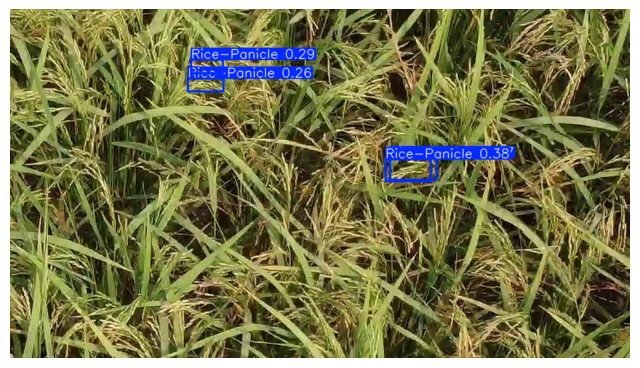

PCA Feature matrix: (1000, 32)


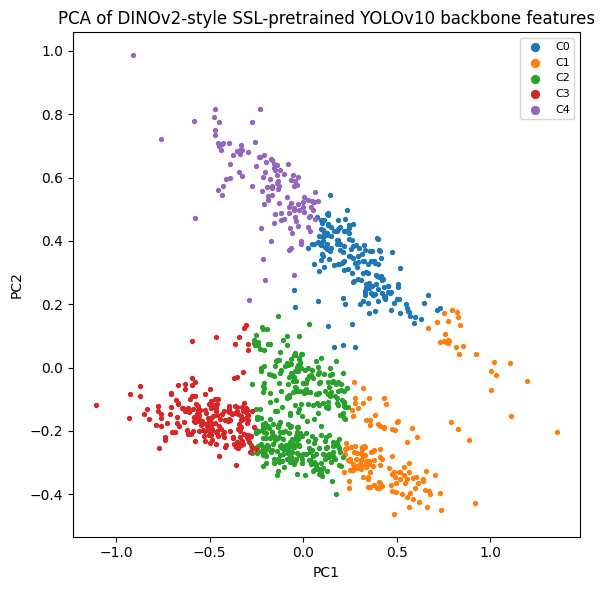

In [1]:
# ===============================================================
# üìú Notebook Summary
# ===============================================================
# This notebook implements a **DINOv2-style Self-Supervised Learning (SSL)**
# pretraining on the **YOLOv10 backbone** (conv net), followed by fine-tuning
# a YOLOv10 detector on your dataset. Finally, it visualizes learned features
# via 2D **PCA** with k-means coloring.
#
# üîπ What's inside:
#   1) COCO ‚Üí YOLO conversion (images/labels + data.yaml).
#   2) SSL pretraining (DINOv2-style):
#       - Student/Teacher (EMA) with cosine momentum schedule
#       - Multi-crop views: 2 global + 8 local
#       - Temperature schedule for teacher + probability centering
#       - Cross-view CE between teacher probs (global) and student logits (all views)
#   3) Save ONLY the SSL-pretrained YOLOv10 backbone weights.
#   4) Fine-tune YOLOv10 detector initialized from those weights.
#   5) Evaluate (mP, mR, mAP@0.50, mAP@0.50‚Äì0.95).
#   6) PCA of backbone features (unsupervised clusters).
#
# üß† Note:
#   - This is a **DINOv2-style adaptation** to a convolutional backbone to keep
#     weights compatible with YOLOv10 detection; official DINOv2 targets ViT backbones.
#   - For stronger transfer: increase SSL_EPOCHS to 50‚Äì100; include more (even unlabeled) images.
# ===============================================================

# ===============================================================
# 0) Setup
# ===============================================================
!pip -q install ultralytics timm

import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

# ===============================================================
# 1) Paths
# ===============================================================
BASE  = Path("/kaggle/input/annotated-rice-panicle-image-from-bangladesh")
WORK  = Path("/kaggle/working/rice_ssl_yolov10_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_rice.yaml"
SSL_W = WORK / "backbone_ssl_v10_dinov2.pt"   # <-- conv backbone weights only
WORK.mkdir(parents=True, exist_ok=True)

# ===============================================================
# 2) COCO -> YOLO conversion (once)
# ===============================================================
def coco2yolo(b,w,h): x,y,bw,bh=b; return (x+bw/2)/w,(y+bh/2)/h,bw/w,bh/h

def convert(split,img_dir,ann_json):
    out_im,out_lb=SPLIT/split/"images",SPLIT/split/"labels"
    out_im.mkdir(parents=True,exist_ok=True)
    out_lb.mkdir(parents=True,exist_ok=True)
    coco=json.load(open(ann_json))
    id2={im["id"]:{k:im[k] for k in ("id","file_name","width","height")} for im in coco["images"]}
    for ann in coco["annotations"]:
        im=id2[ann["image_id"]]; yb=coco2yolo(ann["bbox"],im["width"],im["height"])
        with open(out_lb/f"{Path(im['file_name']).stem}.txt","a") as f:
            f.write(f"{ann['category_id']-1} "+" ".join(f"{v:.6f}" for v in yb)+"\n")
    for im in coco["images"]:
        src = Path(img_dir)/im["file_name"]
        if src.exists():
            shutil.copy(src, out_im/im["file_name"])

if not DATA.exists():
    print("‚û§ Converting COCO ‚Üí YOLO ‚Ä¶")
    convert("train", BASE/"train",  BASE/"train/_annotations.coco.json")
    convert("valid", BASE/"valid",  BASE/"valid/_annotations.coco.json")
    convert("test",  BASE/"valid",  BASE/"valid/_annotations.coco.json")  # simple test = valid
    names=[c["name"] for c in sorted(json.load(open(BASE/'train/_annotations.coco.json'))["categories"],
                                     key=lambda x:x["id"])]
    DATA.write_text(yaml.dump({"path":str(SPLIT),
                               "train":"train/images",
                               "val":"valid/images",
                               "test":"test/images",
                               "nc":len(names),"names":names}))
    print("‚úì YOLO split ready.")
else:
    print("YOLO split already exists")

# ===============================================================
# 3) Multi-crop dataset (DINOv2-style: 2 global + 8 local)
# ===============================================================
class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

# ===============================================================
# 4) YOLOv10 backbone + robust encoder
# ===============================================================
detector = YOLO("yolov10s.yaml")   # requires Ultralytics with YOLOv10 assets
model = detector.model

student_bb = model.model[0].to(device)  # backbone module
teacher_bb = YOLO("yolov10s.yaml").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        if isinstance(t, (list, tuple)) and len(t) and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))     # [B,C,H,W] -> [B,C]
        elif t.ndim == 3:
            z = t.mean(dim=2)         # [B,C,T]   -> [B,C]
        elif t.ndim == 2:
            z = t                      # [B,C]
        else:
            z = t.view(t.size(0), -1)  # fallback flatten
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

# ===============================================================
# 5) Probe REAL crops to get correct feature dim, then build projectors
# ===============================================================
OUT_DIM = 256

# Tiny probe loader (one batch from actual augmentations)
_probe_ds = MultiCropDINO([SPLIT/"train/images"], g_size=224, l_size=96, n_local=1)
_probe_dl = DataLoader(_probe_ds, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

with torch.no_grad():
    probe_views = next(iter(_probe_dl))     # [g1, g2, l1]
    v0 = probe_views[0].to(device)
    feat_dim = student_enc(v0).shape[1]
print("Inferred feature dim from real crop:", feat_dim)

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

# Optional on-the-fly adapters if any batch returns a slightly different feature size
adapters = {}  # key: (in_dim -> feat_dim) => nn.Linear(in_dim, feat_dim).to(device)

# ===============================================================
# 6) DINOv2-style loss (teacher temp warmup + centering)
# ===============================================================
class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss

# ===============================================================
# 7) DINOv2-style SSL pretraining
# ===============================================================
EPOCHS     = 50       # üîÅ increase to 50‚Äì100 for stronger transfer
BATCH      = 16
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.996
N_LOCAL    = 8
NUM_WORKERS= 0

if SSL_W.exists():
    print("‚úì SSL backbone cache found ‚Äì skipping DINOv2-style pretrain")
else:
    print("\nüîÑ  DINOv2-style pretraining on YOLOv10 backbone ‚Ä¶")
    ds = MultiCropDINO([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                # student features
                s_feats = [student_enc(v) for v in views]
                # runtime safety: ensure [B, feat_dim]
                for i, z in enumerate(s_feats):
                    if z.ndim != 2:
                        z = z.view(z.size(0), -1)
                    if z.size(1) != feat_dim:
                        key = (z.size(1), feat_dim)
                        if key not in adapters:
                            adapters[key] = nn.Linear(z.size(1), feat_dim).to(device)
                        z = adapters[key](z)
                    s_feats[i] = z
                s_outs  = [student_head(z) for z in s_feats]              # all crops

                # teacher on globals only (no grad)
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]
                    for i, z in enumerate(t_feats):
                        if z.ndim != 2:
                            z = z.view(z.size(0), -1)
                        if z.size(1) != feat_dim:
                            key = (z.size(1), feat_dim)
                            if key not in adapters:
                                adapters[key] = nn.Linear(z.size(1), feat_dim).to(device)
                            z = adapters[key](z)
                        t_feats[i] = z
                    t_outs  = [teacher_head(z) for z in t_feats]

                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("‚úì Saved SSL YOLOv10 backbone ‚Üí", SSL_W)

# ===============================================================
# 8) Detector fine-tuning (YOLOv10s, init with SSL backbone)
# ===============================================================
det = YOLO("yolov10s.yaml")  # fresh model
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(data=str(DATA),
          epochs=2,
          imgsz=640,
          batch=8,
          project=str(WORK),
          name="ssl_yolov10s_dinov2",
          device=0 if device=="cuda" else "cpu")

# ===============================================================
# 9) Evaluate and visualize one image
# ===============================================================
best_pt = WORK / "ssl_yolov10s_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")

# ===============================================================
# 10) PCA of SSL-pretrained YOLOv10 backbone features
# ===============================================================
det_pca = YOLO("yolov10s.yaml")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

files=[]
for d in [SPLIT/"train/images", SPLIT/"valid/images"]:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)

k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

plt.figure(figsize=(6,6))
for i in range(k):
    m = (lab==i)
    plt.scatter(xy[m,0], xy[m,1], s=8, label=f"C{i}")
plt.title("PCA of DINOv2-style SSL-pretrained YOLOv10 backbone features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()
